In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Problem 4 - Regression
### Part 1

In [2]:
def load_MSD(fname, addBias=True):
    data = np.loadtxt(fname, delimiter=',')
    year, features = data[:, 0], data[:, 1:]
    if addBias:
        features = np.hstack((features, np.ones((features.shape[0], 1))))
    trainYears = year[:463714] 
    trainFeat = features[:463714] 
    testYears = year[463714:] 
    testFeat = features[463714:]
    return trainYears, trainFeat, testYears, testFeat


In [3]:
def musicMSE(pred, gt):
    pred = np.round(pred)
    mse = np.sum(np.square(gt - pred)) / len(gt)
    return mse

In [4]:
trainYears, trainFeat, testYears, testFeat = load_MSD('YearPredictionMSD.txt')
print(trainFeat.shape)
print(trainYears.shape)

(463714, 91)
(463714,)


In [5]:
data = np.loadtxt('YearPredictionMSD.txt', delimiter=',')
year, features = data[:, 0], data[:, 1:]


In [6]:
print(f'min year: {np.min(year)}, max year: {np.max(year)}')
print(f'mode year: {sc.mode(year)}, year std: {np.std(year)}')
print(f'min feature: {np.min(features)}, max feature: {np.max(features)}')
print(f'mean feature: {np.mean(features)}, features std: {np.std(features)}')

min year: 1922.0, max year: 2011.0
mode year: ModeResult(mode=array([2007.]), count=array([39404])), year std: 10.931035748764902
min feature: -14861.69535, max feature: 65735.77953


/var/folders/qf/k7j04sf55hnf6w6bqhpvsgxh0000gn/T/ipykernel_43261/355980159.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print(f'mode year: {sc.mode(year)}, year std: {np.std(year)}')


mean feature: 116.28172933486427, features std: 508.4809347546073


In [7]:
def normalize_MSD(trainFeat, testFeat):
    trainX = trainFeat[:, :-1] #remove bias
    testX = testFeat[:, :-1] #remove bias
    mean_trainX = np.mean(trainX, axis=0)
    std_trainX = np.sqrt(np.sum(np.square(trainX - mean_trainX), axis=0) / (trainX.shape[0] - 1))
    normalized_trainFeat = (trainX - mean_trainX) / std_trainX 
    normalized_testFeat = (testX - mean_trainX) / std_trainX

    normalized_trainFeat = np.hstack((normalized_trainFeat, np.ones((trainX.shape[0], 1)))) #add bias back
    normalized_testFeat = np.hstack((normalized_testFeat, np.ones((testX.shape[0], 1)))) #add bias back
    
    return normalized_trainFeat, normalized_testFeat

In [8]:
ntrainFeat, ntestFeat = normalize_MSD(trainFeat, testFeat)


### Part 2 - Classification:

As we can see from the chart below, they counts are not uniformly distributed, which means that if we treat each year as a descrete classification class, the class sized will be imbalanced, which in turn can affect the results.

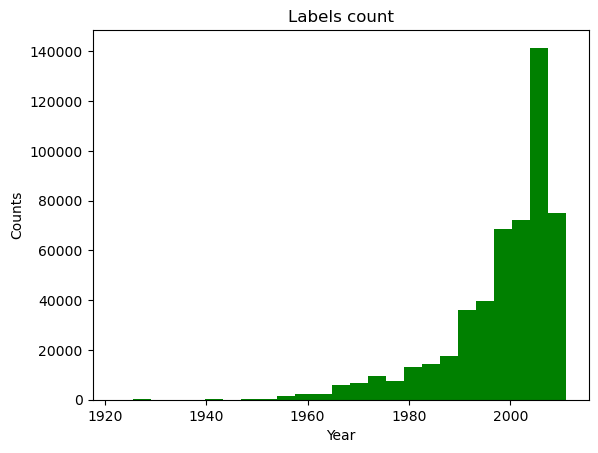

In [9]:
plt.hist(year, bins=25, color='green')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.title('Labels count')
plt.show()

### Mini-Batch SGD Implementation

In [10]:
def minibatch_SGD(X_train, y_train, X_test, y_test, weight_decay_factor, wd_type, loss_f, learning_rate, batch_size, n_epochs):
    
    weights = np.expand_dims(np.zeros(X_train.shape[1]), axis=1)

    train_losses = []
    test_losses = []

    if loss_f == 'L2':
        prediction = lambda train_x, w: train_x @ w
        loss = lambda train_x, train_y, w: np.mean(np.square(prediction(train_x, w) - np.expand_dims(train_y, axis=1)))

        def l2_loss_grad(train_x, train_y, w):
            t = np.multiply(train_x @ w - np.expand_dims(train_y, axis=1), train_x)
            return np.expand_dims(np.mean(2 * t, axis=0), axis=1)
        loss_grad = l2_loss_grad

    elif loss_f == 'count':
        w_decay = lambda w: weight_decay_factor * np.sum(w * w)
        w_decay_grad = lambda w: weight_decay_factor * 2 * w
        prediction = lambda train_x, w: np.exp(train_x @ w)
        def count_loss(train_x, train_y, w):
            pred = prediction(train_x, w)
            t = np.multiply(np.expand_dims(train_y, axis=1), (train_x @ w))
            return np.mean(pred - t + np.expand_dims(train_y, axis=1))
        loss = count_loss

        def count_loss_grad(train_x, train_y, w):
            pred = prediction(train_x, w)
            t = pred - train_y.reshape(-1, 1)
            m = np.multiply(train_x, t)
            return np.mean(m, axis=0).reshape(-1, 1)
        loss_grad = count_loss_grad

    if wd_type == 'L1':
        w_decay = lambda w: weight_decay_factor * np.sum(np.abs(weights))
        w_decay_grad = lambda w: weight_decay_factor * (2 * (weights >= 0) - 1)

    elif wd_type == 'L2':
        w_decay = lambda w: weight_decay_factor * np.sum(w * w)
        w_decay_grad = lambda w: 2 * weight_decay_factor * w

    elif wd_type == 'none':
        w_decay = lambda w: 1
        w_decay_grad = lambda w: 1

    for epoch in range(n_epochs):
        train_loss = w_decay(weights) + loss(X_train, y_train, weights)
        test_loss = w_decay(weights) + loss(X_test, y_test, weights)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f'epoch{epoch} -- train_loss: {train_loss}, test_loss: {test_loss}')

        batch = np.random.choice(X_train.shape[0], batch_size, replace=False)
        batch_x = X_train[batch]
        batch_y = y_train[batch]

        dw_dx = w_decay_grad(weights) + loss_grad(batch_x, batch_y, weights)
        weights -= learning_rate * weight_decay_factor * weights - learning_rate * dw_dx
    
    plt.plot(list(range(len(train_losses))), train_losses, label="Train loss", color = 'green')
    plt.plot(list(range(len(test_losses))), test_losses, label="Test loss", color = 'red')
    plt.title("Loss X Epochs graph")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    return weights



### Part 3 - Training and plotting Ridge Regression, comparing to the Pseudoinverse 

epoch0 -- train_loss: 3993666.588416567, test_loss: 3994103.717282253
epoch1 -- train_loss: 3405216.0739064985, test_loss: 3412434.558813202
epoch2 -- train_loss: 2919059.376569861, test_loss: 2909249.8985813363
epoch3 -- train_loss: 2512206.0785025978, test_loss: 2492522.605912208
epoch4 -- train_loss: 2117150.8979913923, test_loss: 2103487.5731159174
epoch5 -- train_loss: 1797479.8413451104, test_loss: 1789323.8446882982
epoch6 -- train_loss: 1537763.8942870018, test_loss: 1528409.5458365846
epoch7 -- train_loss: 1289456.2483600853, test_loss: 1287863.6060394659
epoch8 -- train_loss: 1111092.4337108277, test_loss: 1100031.7964256562
epoch9 -- train_loss: 934330.6970243421, test_loss: 926926.322036873
epoch10 -- train_loss: 793496.2142231913, test_loss: 785979.2035705119
epoch11 -- train_loss: 691839.330601825, test_loss: 685827.1832159082
epoch12 -- train_loss: 588873.0684237158, test_loss: 583579.0309721453
epoch13 -- train_loss: 491795.2259744186, test_loss: 488642.4342721855
epoch

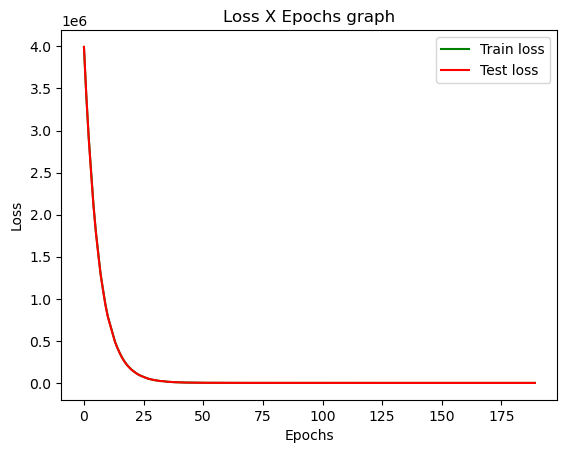

In [11]:
def pseudoInverse(X, y, alpha):
    XXT = X @ X.T
    Ia = np.identity(X.shape[0]) * alpha
    w = (np.linalg.inv(XXT + Ia) @ X).T @ np.expand_dims(y, axis=1)
    return w

w_pseudoinverse = pseudoInverse(ntrainFeat[:10000], trainYears[:10000], alpha=0.01)

weights_Ridge = minibatch_SGD(ntrainFeat, trainYears, ntestFeat, testYears, weight_decay_factor=0.0001, wd_type = 'L2', loss_f="L2", learning_rate=0.04, batch_size=128, n_epochs=190)

In [12]:
print(f'min difference: {np.min(weights_Ridge - w_pseudoinverse)}')
print(f'max difference: {np.max(weights_Ridge - w_pseudoinverse)}')
print(f'mean difference: {np.mean(weights_Ridge - w_pseudoinverse)}')

min difference: -2.223305649175918
max difference: 4.044253293390152
mean difference: 0.035147324380007026


### Part 4 - Training and plotting L1 Lasso Regression

epoch0 -- train_loss: 3993666.588416567, test_loss: 3994103.717282253
epoch1 -- train_loss: 3696712.024203544, test_loss: 3692689.955891793
epoch2 -- train_loss: 3404427.967682757, test_loss: 3398751.481804402
epoch3 -- train_loss: 3140767.8943428225, test_loss: 3134582.7270321916
epoch4 -- train_loss: 2900737.0857741754, test_loss: 2891490.875232398
epoch5 -- train_loss: 2672565.5047394545, test_loss: 2666385.5229387768
epoch6 -- train_loss: 2457122.6841785777, test_loss: 2458663.898610217
epoch7 -- train_loss: 2271220.7354429485, test_loss: 2270444.79353618
epoch8 -- train_loss: 2102807.0176749863, test_loss: 2100146.385634575
epoch9 -- train_loss: 1938576.2918410397, test_loss: 1941505.1620574614
epoch10 -- train_loss: 1798634.9024070322, test_loss: 1796616.8279127788
epoch11 -- train_loss: 1657343.0394548222, test_loss: 1654290.5525194833
epoch12 -- train_loss: 1536907.1955073217, test_loss: 1531263.332015738
epoch13 -- train_loss: 1401582.0748279584, test_loss: 1408360.8253927964


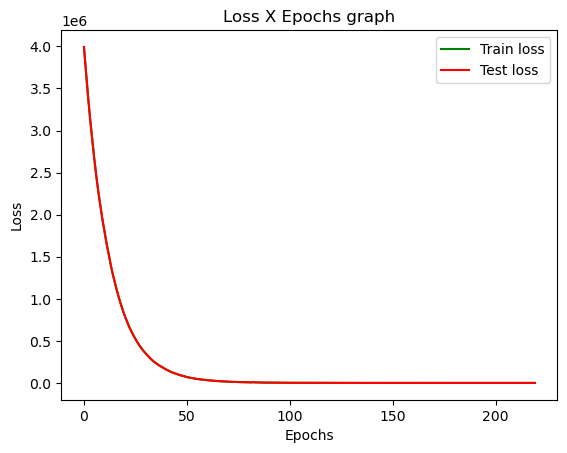

In [13]:
weights_Lasso = minibatch_SGD(ntrainFeat, trainYears, ntestFeat, testYears, weight_decay_factor=0.0009, wd_type = 'L1', loss_f="L2", learning_rate=0.02, batch_size=150, n_epochs=220)


### Part 5 - Training and plotting Count regression

epoch0 -- train_loss: 2000.386076331532, test_loss: 2000.495922992001
epoch1 -- train_loss: 1988.4224658713542, test_loss: 1988.3196050853865
epoch2 -- train_loss: 1976.469546388081, test_loss: 1976.4466432966967
epoch3 -- train_loss: 1964.50937631145, test_loss: 1964.8013976706925
epoch4 -- train_loss: 1952.555436324688, test_loss: 1952.92057410124
epoch5 -- train_loss: 1940.5748212050337, test_loss: 1940.539188001247
epoch6 -- train_loss: 1928.6185893779566, test_loss: 1928.1017179919927
epoch7 -- train_loss: 1916.6693717077774, test_loss: 1916.3986694602281
epoch8 -- train_loss: 1904.7150192576817, test_loss: 1904.1183039496975
epoch9 -- train_loss: 1892.741723852462, test_loss: 1892.8288056655085
epoch10 -- train_loss: 1880.8085492990983, test_loss: 1880.8346613007382
epoch11 -- train_loss: 1868.8506745992934, test_loss: 1869.532057020814
epoch12 -- train_loss: 1856.8876640968756, test_loss: 1857.621154428078
epoch13 -- train_loss: 1844.9415743705063, test_loss: 1845.5860600796254


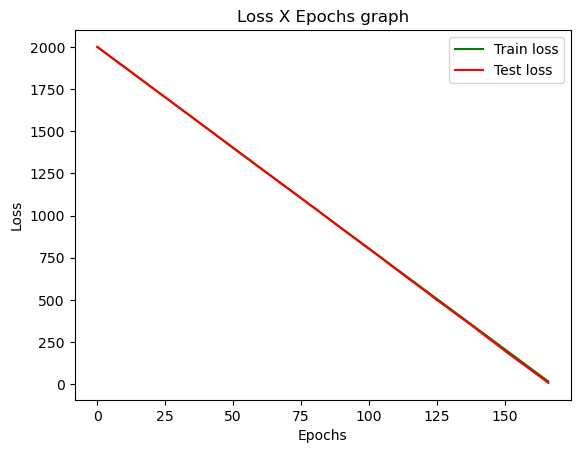

In [14]:
weights_count = minibatch_SGD(ntrainFeat, trainYears, ntestFeat, testYears, weight_decay_factor=0.01, wd_type = 'none', loss_f="count", learning_rate=0.000003, batch_size=64, n_epochs=167)

### Part 6 - Model Comparison

#### Ridge Regression 

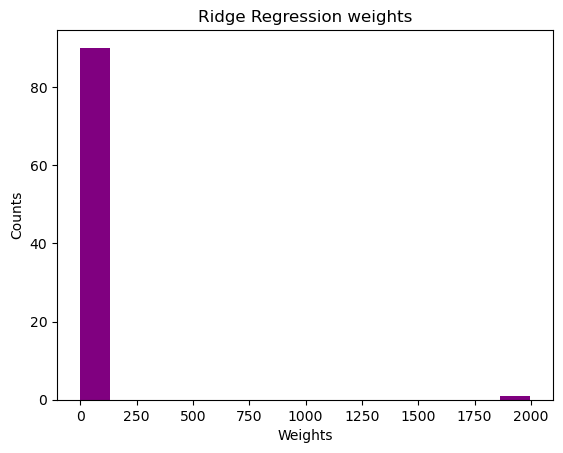

In [15]:
plt.hist(weights_Ridge, bins=15, color='purple')
plt.title("Ridge Regression weights")
plt.xlabel("Weights")
plt.ylabel("Counts")
plt.show()

In [16]:
plt.hist(weights_Lasso, bins=15, color='green')
plt.title("Lasso Regression weights")
plt.xlabel("Weights")
plt.ylabel("Counts")
plt.show()

NameError: name 'weights_Lasso' is not defined

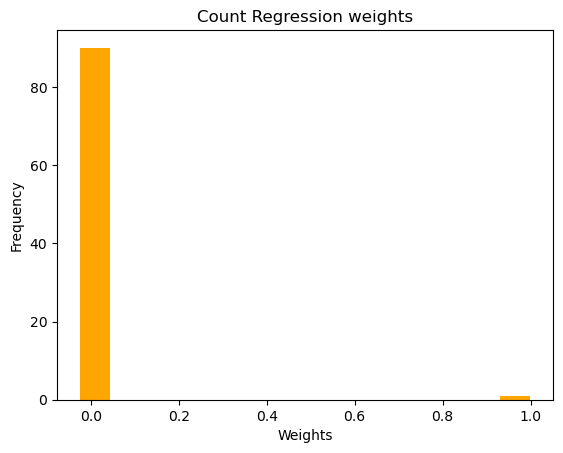

In [17]:
plt.hist(weights_count, bins=15, color='orange')
plt.title("Count Regression weights")
plt.xlabel("Weights")
plt.ylabel("Frequency")
plt.show()

## Problem 6 - Implementing a Softmax Classifier

##### Write a function to load the data and the labels, which are returned as NumPy arrays.

In [5]:
def loadIris():
    trIris = np.loadtxt('iris-train.txt')
    tsIris = np.loadtxt('iris-test.txt')

    trIrisX = trIris[: , 1:]
    trIrisy = trIris[: , 0]
    tsIrisX = tsIris[: , 1:]
    tsIrisy = tsIris[: , 0]

    return trIrisX, trIrisy, tsIrisX, tsIrisy

In [8]:
trainIrisX, trainIrisy, testIrisX, testIrisy = loadIris()

In [9]:
def normalize_Iris(trainX, testX):
    
    minX = np.min(trainX, axis=0)
    maxX = np.max(trainX, axis=0)

    trainX_normalized = (((trainX - minX) / (maxX - minX)) * 2) - 1
    testX_normalized = (((testX - minX) / (maxX - minX)) * 2) - 1

    trainX_normalized = np.hstack((trainX_normalized, np.ones((trainX_normalized.shape[0], 1)))) #add bias
    testX_normalized = np.hstack((testX_normalized, np.ones((testX_normalized.shape[0], 1)))) # add bias

    return trainX_normalized, testX_normalized

In [10]:
n_trainIris, n_testIris = normalize_Iris(trainIrisX, testIrisX)

### Part 1 - Implementation and Evaluation

In [22]:
np.unique(trainIrisy).shape[0]

3

In [152]:
def minibatch_SGD_softmax(X_train, y_train, X_test, y_test, weight_decay_factor, momentum_rate, learning_rate, batch_size, n_epochs):
    K = np.unique(y_train).shape[0]
    weights = np.random.normal(loc=0, scale=1, size=(K, X_train.shape[1]))
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []

    def softmax(x):
            exp = np.exp(x - np.expand_dims(np.max(x, axis=1), axis=1))
            sumexp = np.sum(exp, axis=1)
            return exp/np.expand_dims(sumexp, axis=1)

    def loss(X, y, w):
        y_ohe = np.zeros((y.size, K))
        y_ohe[np.arange(y.size), y.astype(int)] = 1
        
        cross_entropy = np.multiply(np.log(softmax(X @ w.T)), y_ohe)
        return -np.sum(cross_entropy)/X.shape[0]
    
    def prediction(X, y, w):
        return np.argmax(X @ w.T, axis=1)
    
    def mean_accuracy(X, y, w):
        return np.sum(prediction(X, y, w) == y) / prediction(X, y, w).shape[0]
    
    best_test_accuracy = 0
    momentum_opt = 0
    best_weights = None

    for epoch in range(n_epochs):
        mean_acc_tr =  mean_accuracy(X_train, y_train, weights)
        mean_acc_ts = mean_accuracy(X_test, y_test, weights)
        batch_selection = np.random.choice(X_train.shape[0], batch_size, replace=False)
        batch_x = X_train[batch_selection].astype(int)
        batch_y = y_train[batch_selection].astype(int)

        batch_y_ohe = np.zeros((batch_y.size, K))
        batch_y_ohe[np.arange(batch_y.size), batch_y] = 1

        

        train_accuracies.append(mean_acc_tr)
        test_accuracies.append(mean_acc_ts)

        if mean_acc_ts > best_test_accuracy:
            best_test_accuracy = mean_acc_ts
            best_weights = weights
            print(f'new best test accuracy: {mean_acc_ts} in epoch {epoch}')
        
        training_loss = loss(X_train, y_train, weights)
        test_loss = loss(X_test, y_test, weights)
        train_losses.append(training_loss)
        test_losses.append(test_loss)

        dw_dx = (softmax(batch_x @ weights.T) - batch_y_ohe).T @ batch_x

        momentum = learning_rate * dw_dx + momentum_opt * momentum_rate
        weights -= momentum * weight_decay_factor
        momentum_opt = momentum

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(list(range(n_epochs)), train_losses, label='Train loss', color='green')
    ax1.plot(list(range(n_epochs)), test_losses, label = 'Test loss', color = 'red')
    ax2.plot(list(range(n_epochs)), train_accuracies, label='Train accuracy', color = 'green')
    ax2.plot(list(range(n_epochs)), test_accuracies, label = 'Test accuracy', color = 'red')
    ax1.set_title("Cross-entropy loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Average loss")
    ax2.set_title("Mean Accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax1.legend()
    ax2.legend()
    print(f'best test accuracy {round(best_test_accuracy * 100, 2)}%', )

    return best_weights
        



new best test accuracy: 0.39215686274509803 in epoch 0
new best test accuracy: 0.4117647058823529 in epoch 22
new best test accuracy: 0.43137254901960786 in epoch 26
new best test accuracy: 0.45098039215686275 in epoch 27
new best test accuracy: 0.47058823529411764 in epoch 59
new best test accuracy: 0.49019607843137253 in epoch 85
new best test accuracy: 0.5098039215686274 in epoch 93
new best test accuracy: 0.5294117647058824 in epoch 96
new best test accuracy: 0.5490196078431373 in epoch 101
new best test accuracy: 0.5686274509803921 in epoch 103
new best test accuracy: 0.5882352941176471 in epoch 145
new best test accuracy: 0.6078431372549019 in epoch 181
new best test accuracy: 0.6274509803921569 in epoch 211
new best test accuracy: 0.6470588235294118 in epoch 229
new best test accuracy: 0.6666666666666666 in epoch 289
new best test accuracy: 0.6862745098039216 in epoch 303
best test accuracy 68.63%


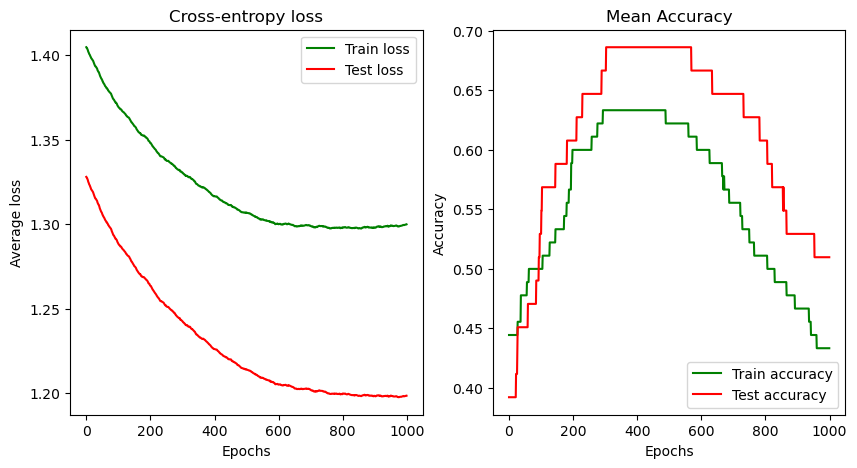

In [146]:
softmax_weights = minibatch_SGD_softmax(n_trainIris, trainIrisy-1, n_testIris, testIrisy-1, weight_decay_factor=0.01, momentum_rate=0.2, learning_rate=0.02, batch_size=16, n_epochs = 1000)

In [147]:
predictionIris = n_trainIris @ softmax_weights.T
labelsIris = np.argmax(predictionIris, axis=1)
print(labelsIris+1)

[1 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1 1
 1 1 1 2 1 2 2 1 1 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2
 2 1 2 2 2 2 2 2 2 2 2 2 1 1 2 2]


In [148]:
class SoftmaxClassifier():
    def __init__(self, weights):
        self.weights = weights

    def predict(self, X):
        y_pred = X @ self.weights[:, [0,2]].T
        return np.argmax(y_pred, axis=1)

Text(0.5, 1.0, 'Decision Boundaries Plot')

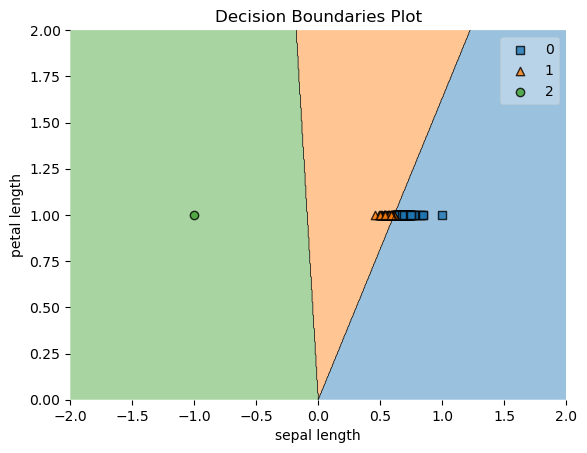

In [151]:
from mlxtend.plotting import plot_decision_regions
classifier = SoftmaxClassifier(softmax_weights)
X = n_trainIris[:, [0, 2]]
preds = classifier.predict(X)

plot_decision_regions(X, preds, clf=classifier,)
plt.xlabel('sepal length')
plt.ylabel('petal length')
plt.title('Decision Boundaries Plot')


### Part 2 - Plotting decision boundaries



## Problem 7 - Classifying Images

In [38]:
from keras.datasets import cifar10
(cifar10_trainX, cifar10_trainy), (cifar10_testX, cifar10_testy) = cifar10.load_data()

2023-03-06 14:38:44.452462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [39]:
def normalizeCIFAR(Ctrain, Ctest):
    feature_n = Ctrain.shape[1] * Ctrain.shape[2] * Ctrain.shape[3] #heigght * width * n_channels
    Ctrain_flat = Ctrain.reshape(Ctrain.shape[0], feature_n)
    Ctest_flat = Ctest.reshape(Ctest.shape[0], feature_n)
    
    mean = np.mean(Ctrain_flat, axis=0)
    std = np.sqrt(np.sum(np.square(Ctrain_flat - mean), axis=0) / (Ctrain.shape[0] - 1))

    nCtrain = (Ctrain_flat - mean)/std
    nCtest = (Ctest_flat - mean)/std 

    return nCtrain, nCtest


In [40]:
norm_cifar_trX, norm_cifar_tsX = normalizeCIFAR(cifar10_trainX, cifar10_testX)

new best test accuracy: 0.0837 in epoch 0
new best test accuracy: 0.1019 in epoch 1
new best test accuracy: 0.1521 in epoch 2
new best test accuracy: 0.1696 in epoch 3
new best test accuracy: 0.1716 in epoch 4
new best test accuracy: 0.1805 in epoch 7
new best test accuracy: 0.1835 in epoch 8
new best test accuracy: 0.1898 in epoch 10
new best test accuracy: 0.2022 in epoch 11
new best test accuracy: 0.2037 in epoch 12
new best test accuracy: 0.2045 in epoch 14
new best test accuracy: 0.2099 in epoch 15
new best test accuracy: 0.2114 in epoch 16
new best test accuracy: 0.2227 in epoch 17
new best test accuracy: 0.2244 in epoch 24
new best test accuracy: 0.2291 in epoch 26
new best test accuracy: 0.2306 in epoch 27
new best test accuracy: 0.2447 in epoch 29
new best test accuracy: 0.2507 in epoch 39
new best test accuracy: 0.2515 in epoch 57
new best test accuracy: 0.2547 in epoch 65
new best test accuracy: 0.2574 in epoch 71
new best test accuracy: 0.2584 in epoch 74
new best test accu

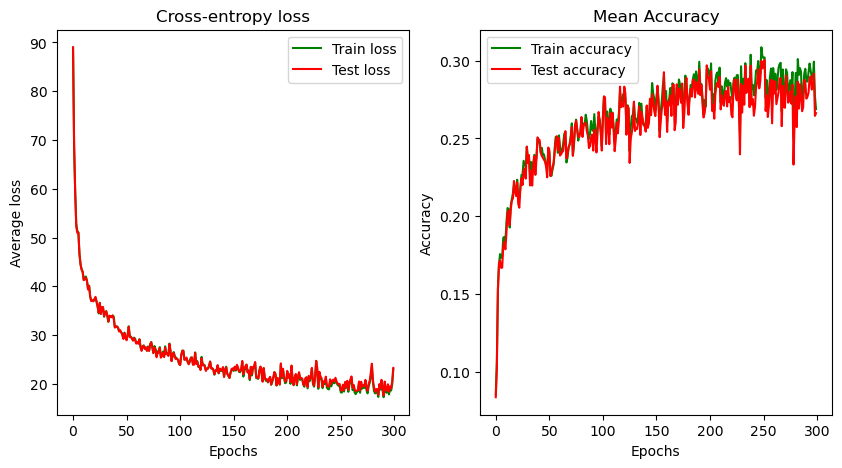

In [75]:
cifar_weights = minibatch_SGD_softmax(norm_cifar_trX, cifar10_trainy.flatten(), norm_cifar_tsX, cifar10_testy.flatten(), 0.3, 0.2, 0.01, 150, 300)

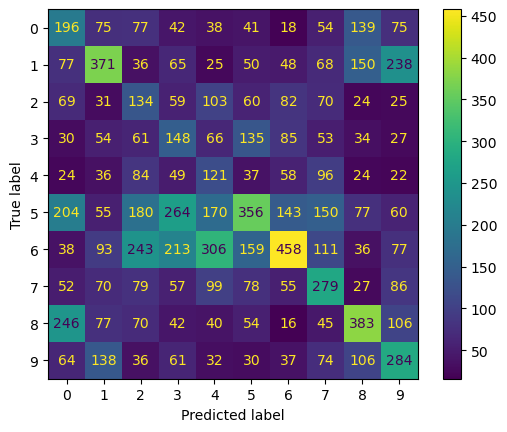

In [101]:
cifar_preds = norm_cifar_tsX @ cifar_weights.T
cifar_label_preds = np.argmax(cifar_preds, axis = 1)
conf_m = confusion_matrix(cifar_label_preds, cifar10_testy, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
conf_m_display = ConfusionMatrixDisplay(confusion_matrix=conf_m, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
conf_m_display.plot()
